# Kalman Filter

> This Tutorial is fetched from [Kalman Filter](https://medium.com/@ab.jannatpour/kalman-filter-with-python-code-98641017a2bd)

Initialize the filter with an initial estimate of the state and the associated uncertainty (covariance)
At each time step:

a. Prediction step: use the model of the system’s dynamics to predict the state of the system at the next time step based on the current estimate of the state
b. Correction step:
i. Compute the Kalman gain, which is a measure of how much the new measurement data should be trusted relative to the prediction

ii. Update the estimate of the state based on the new measurement data and the Kalman gain.

iii. Update the uncertainty (covariance) of the estimate

The output of the filter is the estimated state of the system at each time step.

In [ ]:
#| default_exp kalman_filter

In [ ]:
from pykalman import KalmanFilter
import numpy as np

# Define the initial state and transition matrix
x_init = np.array([0, 0])
transition_matrix = [[1, 1], [0, 1]]

# Define the measurement matrix and measurement noise
measurement_matrix = [[1, 0]]
measurement_noise = np.array([[0.1]])

# Define the process noise
process_noise = np.array([[0.1, 0.1], [0.1, 0.2]])

# Create the Kalman filter
kf = KalmanFilter(transition_matrices=transition_matrix,
                  observation_matrices=measurement_matrix,
                  initial_state_mean=x_init,
                  observation_covariance=measurement_noise,
                  transition_covariance=process_noise)

# Generate some fake measurements
measurements = np.random.randn(50, 1)

# Run the Kalman filter
(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)

In [ ]:
import numpy as np
 
# Author: Addison Sears-Collins
# https://automaticaddison.com
# Description: Extended Kalman Filter example (two-wheeled mobile robot)
 
# Supress scientific notation when printing NumPy arrays
np.set_printoptions(precision=3,suppress=True)
 
# A matrix
# 3x3 matrix -> number of states x number of states matrix
# Expresses how the state of the system [x,y,yaw] changes 
# from k-1 to k when no control command is executed.
# Typically a robot on wheels only drives when the wheels are told to turn.
# For this case, A is the identity matrix.
# A is sometimes F in the literature.
A_k_minus_1 = np.array([[1.0,  0,   0],
                                                [  0,1.0,   0],
                                                [  0,  0, 1.0]])
 
# Noise applied to the forward kinematics (calculation
# of the estimated state at time k from the state
# transition model of the mobile robot). This is a vector
# with the number of elements equal to the number of states
process_noise_v_k_minus_1 = np.array([0.01,0.01,0.003])
     
# State model noise covariance matrix Q_k
# When Q is large, the Kalman Filter tracks large changes in 
# the sensor measurements more closely than for smaller Q.
# Q is a square matrix that has the same number of rows as states.
Q_k = np.array([[1.0,   0,   0],
                                [  0, 1.0,   0],
                                [  0,   0, 1.0]])
                 
# Measurement matrix H_k
# Used to convert the predicted state estimate at time k
# into predicted sensor measurements at time k.
# In this case, H will be the identity matrix since the 
# estimated state maps directly to state measurements from the 
# odometry data [x, y, yaw]
# H has the same number of rows as sensor measurements
# and same number of columns as states.
H_k = np.array([[1.0,  0,   0],
                                [  0,1.0,   0],
                                [  0,  0, 1.0]])
                         
# Sensor measurement noise covariance matrix R_k
# Has the same number of rows and columns as sensor measurements.
# If we are sure about the measurements, R will be near zero.
R_k = np.array([[1.0,   0,    0],
                                [  0, 1.0,    0],
                                [  0,    0, 1.0]])  
                 
# Sensor noise. This is a vector with the
# number of elements equal to the number of sensor measurements.
sensor_noise_w_k = np.array([0.07,0.07,0.04])
 
def getB(yaw, deltak):
    """
    Calculates and returns the B matrix
    3x2 matix -> number of states x number of control inputs
    The control inputs are the forward speed and the
    rotation rate around the z axis from the x-axis in the 
    counterclockwise direction.
    [v,yaw_rate]
    Expresses how the state of the system [x,y,yaw] changes
    from k-1 to k due to the control commands (i.e. control input).
    :param yaw: The yaw angle (rotation angle around the z axis) in rad 
    :param deltak: The change in time from time step k-1 to k in sec
    """
    B = np.array([  [np.cos(yaw)*deltak, 0],
                                    [np.sin(yaw)*deltak, 0],
                                    [0, deltak]])
    return B
 
def ekf(z_k_observation_vector, state_estimate_k_minus_1, 
        control_vector_k_minus_1, P_k_minus_1, dk):
    """
    Extended Kalman Filter. Fuses noisy sensor measurement to 
    create an optimal estimate of the state of the robotic system.
         
    INPUT
        :param z_k_observation_vector The observation from the Odometry
            3x1 NumPy Array [x,y,yaw] in the global reference frame
            in [meters,meters,radians].
        :param state_estimate_k_minus_1 The state estimate at time k-1
            3x1 NumPy Array [x,y,yaw] in the global reference frame
            in [meters,meters,radians].
        :param control_vector_k_minus_1 The control vector applied at time k-1
            3x1 NumPy Array [v,v,yaw rate] in the global reference frame
            in [meters per second,meters per second,radians per second].
        :param P_k_minus_1 The state covariance matrix estimate at time k-1
            3x3 NumPy Array
        :param dk Time interval in seconds
             
    OUTPUT
        :return state_estimate_k near-optimal state estimate at time k  
            3x1 NumPy Array ---> [meters,meters,radians]
        :return P_k state covariance_estimate for time k
            3x3 NumPy Array                 
    """
    ######################### Predict #############################
    # Predict the state estimate at time k based on the state 
    # estimate at time k-1 and the control input applied at time k-1.
    state_estimate_k = A_k_minus_1 @ (
            state_estimate_k_minus_1) + (
            getB(state_estimate_k_minus_1[2],dk)) @ (
            control_vector_k_minus_1) + (
            process_noise_v_k_minus_1)
             
    print(f'State Estimate Before EKF={state_estimate_k}')
             
    # Predict the state covariance estimate based on the previous
    # covariance and some noise
    P_k = A_k_minus_1 @ P_k_minus_1 @ A_k_minus_1.T + (
            Q_k)
         
    ################### Update (Correct) ##########################
    # Calculate the difference between the actual sensor measurements
    # at time k minus what the measurement model predicted 
    # the sensor measurements would be for the current timestep k.
    measurement_residual_y_k = z_k_observation_vector - (
            (H_k @ state_estimate_k) + (
            sensor_noise_w_k))
 
    print(f'Observation={z_k_observation_vector}')
             
    # Calculate the measurement residual covariance
    S_k = H_k @ P_k @ H_k.T + R_k
         
    # Calculate the near-optimal Kalman gain
    # We use pseudoinverse since some of the matrices might be
    # non-square or singular.
    K_k = P_k @ H_k.T @ np.linalg.pinv(S_k)
         
    # Calculate an updated state estimate for time k
    state_estimate_k = state_estimate_k + (K_k @ measurement_residual_y_k)
     
    # Update the state covariance estimate for time k
    P_k = P_k - (K_k @ H_k @ P_k)
     
    # Print the best (near-optimal) estimate of the current state of the robot
    print(f'State Estimate After EKF={state_estimate_k}')
 
    # Return the updated state and covariance estimates
    return state_estimate_k, P_k
     
def main():
 
    # We start at time k=1
    k = 1
     
    # Time interval in seconds
    dk = 1
 
    # Create a list of sensor observations at successive timesteps
    # Each list within z_k is an observation vector.
    z_k = np.array([[4.721,0.143,0.006], # k=1
                    [9.353,0.284,0.007], # k=2
                    [14.773,0.422,0.009],# k=3
                    [18.246,0.555,0.011], # k=4
                    [22.609,0.715,0.012]])# k=5
                     
    # The estimated state vector at time k-1 in the global reference frame.
    # [x_k_minus_1, y_k_minus_1, yaw_k_minus_1]
    # [meters, meters, radians]
    state_estimate_k_minus_1 = np.array([0.0,0.0,0.0])
     
    # The control input vector at time k-1 in the global reference frame.
    # [v, yaw_rate]
    # [meters/second, radians/second]
    # In the literature, this is commonly u.
    # Because there is no angular velocity and the robot begins at the 
    # origin with a 0 radians yaw angle, this robot is traveling along 
    # the positive x-axis in the global reference frame.
    control_vector_k_minus_1 = np.array([4.5,0.0])
     
    # State covariance matrix P_k_minus_1
    # This matrix has the same number of rows (and columns) as the 
    # number of states (i.e. 3x3 matrix). P is sometimes referred
    # to as Sigma in the literature. It represents an estimate of 
    # the accuracy of the state estimate at time k made using the
    # state transition matrix. We start off with guessed values.
    P_k_minus_1 = np.array([[0.1,  0,   0],
                                                    [  0,0.1,   0],
                                                    [  0,  0, 0.1]])
                             
    # Start at k=1 and go through each of the 5 sensor observations, 
    # one at a time. 
    # We stop right after timestep k=5 (i.e. the last sensor observation)
    for k, obs_vector_z_k in enumerate(z_k,start=1):
     
        # Print the current timestep
        print(f'Timestep k={k}')  
         
        # Run the Extended Kalman Filter and store the 
        # near-optimal state and covariance estimates
        optimal_state_estimate_k, covariance_estimate_k = ekf(
            obs_vector_z_k, # Most recent sensor measurement
            state_estimate_k_minus_1, # Our most recent estimate of the state
            control_vector_k_minus_1, # Our most recent control input
            P_k_minus_1, # Our most recent state covariance matrix
            dk) # Time interval
         
        # Get ready for the next timestep by updating the variable values
        state_estimate_k_minus_1 = optimal_state_estimate_k
        P_k_minus_1 = covariance_estimate_k
         
        # Print a blank line
        print()
 
# Program starts running here with the main method  
main()

Timestep k=1
State Estimate Before EKF=[4.51  0.01  0.003]
Observation=[4.721 0.143 0.006]
State Estimate After EKF=[ 4.584  0.043 -0.016]

Timestep k=2
State Estimate Before EKF=[ 9.093 -0.021 -0.013]
Observation=[9.353 0.284 0.007]
State Estimate After EKF=[ 9.208  0.121 -0.025]

Timestep k=3
State Estimate Before EKF=[13.716  0.017 -0.022]
Observation=[14.773  0.422  0.009]
State Estimate After EKF=[14.324  0.224 -0.028]

Timestep k=4
State Estimate Before EKF=[18.832  0.109 -0.025]
Observation=[18.246  0.555  0.011]
State Estimate After EKF=[18.427  0.341 -0.027]

Timestep k=5
State Estimate Before EKF=[22.935  0.228 -0.024]
Observation=[22.609  0.715  0.012]
State Estimate After EKF=[22.69   0.486 -0.027]



In [ ]:
import matplotlib.pyplot as plt
from sklearn import datasets

iris = datasets.load_iris()
_, ax = plt.subplots()
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)

In [ ]:
# Import necessary modules 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.datasets import load_iris 

# Loading data 
irisData = load_iris() 

# Create feature and target arrays 
X = irisData.data 
y = irisData.target 

# Split into training and test set 
X_train, X_test, y_train, y_test = train_test_split( 
			X, y, test_size = 0.2, random_state=42) 

knn = KNeighborsClassifier(n_neighbors=7) 

knn.fit(X_train, y_train) 

# Predict on dataset which model has not seen before 
print(knn.predict(X_test)) 

[1 0 2 1 1 0 1 2 2 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0]


In [ ]:

# Import necessary modules 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.datasets import load_iris 
  
# Loading data 
irisData = load_iris() 
  
# Create feature and target arrays 
X = irisData.data 
y = irisData.target 
  
# Split into training and test set 
X_train, X_test, y_train, y_test = train_test_split( 
             X, y, test_size = 0.2, random_state=42) 
  
knn = KNeighborsClassifier(n_neighbors=7) 
  
knn.fit(X_train, y_train) 
  
# Calculate the accuracy of the model 
print(knn.score(X_test, y_test)) 

0.9666666666666667


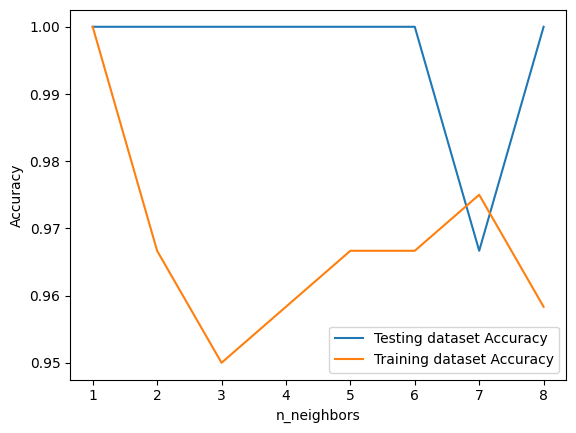

In [ ]:
# Import necessary modules 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.datasets import load_iris 
import numpy as np 
import matplotlib.pyplot as plt 

irisData = load_iris() 

# Create feature and target arrays 
X = irisData.data 
y = irisData.target 

# Split into training and test set 
X_train, X_test, y_train, y_test = train_test_split( 
			X, y, test_size = 0.2, random_state=42) 

neighbors = np.arange(1, 9) 
train_accuracy = np.empty(len(neighbors)) 
test_accuracy = np.empty(len(neighbors)) 

# Loop over K values 
for i, k in enumerate(neighbors): 
	knn = KNeighborsClassifier(n_neighbors=k) 
	knn.fit(X_train, y_train) 
	
	# Compute training and test data accuracy 
	train_accuracy[i] = knn.score(X_train, y_train) 
	test_accuracy[i] = knn.score(X_test, y_test) 

# Generate plot 
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy') 
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy') 

plt.legend() 
plt.xlabel('n_neighbors') 
plt.ylabel('Accuracy') 
plt.show() 


In [ ]:
#| hide
import numpy as np
from scipy.linalg import inv

In [ ]:
#| export

# Linear Kalman Filter
class KalmanFilter:
    def __init__(self, transition_matrix:np.array, # system model
                 measurment_matrix:np.array, # measurement model
                 init_state:np.array, # initial state
                 state_cov:np.array, # initial state covariance]
                 process_noise_cov:np.array, # process noise covariance
                 measurement_noise_cov:np.array # measurement noise covariance
                 ) -> None:
        self.A = transition_matrix
        self.H = measurment_matrix
        self.x = init_state
        self.P = state_cov
        self.Q = process_noise_cov
        self.R = measurement_noise_cov

    def predict(self) -> None:
        self.x = self.A.dot(self.x)
        self.P = self.A.dot(self.P).dot(self.A.T) + self.Q
    
    def correct(self) -> np.array:
        z = self.H.dot(self.x) + np.random.normal(0, np.sqrt(self.R))
        return z - self.H.dot(self.x)
    
    def compute_kalman_gain(self) -> np.array: # Kalman Gain
        '''
        The Kalman gain is calculated by multiplying the predicted state covariance by
        the transpose of the measurement model and dividing it by the innovation covariance.
        '''
        # innovation covariance
        S = self.H.dot(self.P).dot(self.H.T) + self.R
        return self.P.dot(self.H.T).dot(inv(S))

    def update(self) -> None:
        y = self.correct()
        self.K = self.compute_kalman_gain()
        self.x = self.x + self.K.dot(y)
        self.P = self.P - self.K.dot(self.H).dot(self.P)


In [ ]:
#| hide
# system model
A = np.array([[1, 1], [0, 1]])

# measurement model
H = np.array([[1, 0]])

# initial state
x = np.array([[0], [0]])

# initial state covariance
P = np.array([[1, 0], [0, 1]])

# measurement noise covariance
R = np.array([[1e-2]])

# process noise covariance
Q = np.array([[1e-4, 1e-4], [1e-4, 1e-4]])

KF = KalmanFilter(transition_matrix = A,
                 measurment_matrix = H,
                 init_state = x,
                 state_cov = P,
                 measurement_noise_cov = R,
                 process_noise_cov = Q) 

In [ ]:
for i in range(10):
    print('iter # {}'.format(i))
    print('Init State: {}'.format(KF.x))
    KF.predict()
    print('State after prediction: {}'.format(KF.x))
    KF.update()
    print('Kalman Gain: {}'.format(KF.K))
    print('State after correction: {}'.format(KF.x))

iter # 0
Init State: [[0]
 [0]]
State after prediction: [[0]
 [0]]
Kalman Gain: [[0.995]
 [0.498]]
State after correction: [[-0.045]
 [-0.023]]
iter # 1
Init State: [[-0.045]
 [-0.023]]
State after prediction: [[-0.068]
 [-0.023]]
Kalman Gain: [[0.981]
 [0.953]]
State after correction: [[0.036]
 [0.078]]
iter # 2
Init State: [[0.036]
 [0.078]]
State after prediction: [[0.113]
 [0.078]]
Kalman Gain: [[0.827]
 [0.492]]
State after correction: [[0.035]
 [0.031]]
iter # 3
Init State: [[0.035]
 [0.031]]
State after prediction: [[0.067]
 [0.031]]
Kalman Gain: [[0.698]
 [0.3  ]]
State after correction: [[0.114]
 [0.052]]
iter # 4
Init State: [[0.114]
 [0.052]]
State after prediction: [[0.165]
 [0.052]]
Kalman Gain: [[0.602]
 [0.204]]
State after correction: [[0.091]
 [0.026]]
iter # 5
Init State: [[0.091]
 [0.026]]
State after prediction: [[0.118]
 [0.026]]
Kalman Gain: [[0.53 ]
 [0.152]]
State after correction: [[0.092]
 [0.019]]
iter # 6
Init State: [[0.092]
 [0.019]]
State after prediction

## Simple Kalman Filter

In [ ]:
#| export
# Initialize the filter with an initial estimate of the position and the associated uncertainty (covariance)
x_estimated = 0
P_estimated = 1

# Define the velocity and the process noise
velocity = 1
process_noise = 0.1

# Define the measurement noise
measurement_noise = 0.1

for i in range(10):
    # Generate a measurement with some random noise
    measurement = i + np.random.normal(0, measurement_noise)

    # Prediction step
    x_predicted = x_estimated + velocity
    P_predicted = P_estimated + process_noise

    # Correction step
    K = P_predicted / (P_predicted + measurement_noise)
    x_estimated = x_predicted + K * (measurement - x_predicted)
    P_estimated = (1 - K) * P_predicted

    # Print the estimated position
    print("Estimated position: {}".format(x_estimated))

Estimated position: 0.2582047088244377
Estimated position: 1.1016831312210598
Estimated position: 2.0154357549307265
Estimated position: 3.1283296198759736
Estimated position: 4.075512759872741
Estimated position: 4.912716119364204
Estimated position: 5.903275419172371
Estimated position: 6.849880565886684
Estimated position: 7.908031124234666
Estimated position: 9.035073449381617


## 2D Kalman Filter

In [ ]:
# Initialize the filter with an initial estimate of the position and velocity and the associated uncertainty (covariance)
x_estimated = np.array([0, 0])
P_estimated = np.eye(2)

# Define the state transition matrix
A = np.array([[1, 1], [0, 1]])

# Define the measurement matrix
H = np.array([[1, 0]])

# Define the measurement noise
R = np.array([[0.1]])

# Define the process noise
Q = np.array([[0.1, 0.1], [0.1, 0.2]])

for i in range(10):
    # Generate a measurement with some random noise
    measurement = i + np.random.normal(0, 0.1)

    # Prediction step
    x_predicted = np.dot(A, x_estimated)
    P_predicted = np.dot(A, np.dot(P_estimated, A.T)) + Q

    # Correction step
    K = np.dot(P_predicted, np.dot(H.T, np.linalg.inv(np.dot(H, np.dot(P_predicted, H.T)) + R)))
    x_estimated = x_predicted + np.dot(K, (measurement - np.dot(H, x_predicted)))
    P_estimated = np.dot((np.eye(2) - np.dot(K, H)), P_predicted)

    # Print the estimated position and velocity
    print("Estimated position: ", x_estimated[0])
    print("Estimated velocity: ", x_estimated[1])

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()